In [1]:
pip install lean

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# =========================================================
# 0) Install & Imports
# =========================================================
!pip install -q yfinance fredapi pandas-datareader pandas numpy

import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred
from datetime import datetime

# Nice display
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 50)

# =========================================================
# 1) Config
# =========================================================
FRED_API_KEY = "534b28f943deb64dc3430cd349ea400d"   # <-- put your key here
START = "2014-12-31"                      # small pre-window for lags
END   = "2025-06-02"

# =========================================================
# 2) Download SPY (daily) — master trading calendar
# =========================================================
spy = yf.download("SPY", start=START, end=END, interval="1d", auto_adjust=False)
spy.index = pd.to_datetime(spy.index)
spy = spy.sort_index()
print("SPY shape:", spy.shape)
print(spy.head(3))

# =========================================================
# 3) Macro from FRED (no ISM/PMI on FRED; we use close proxies)
#    - CPI, Core PCE, Payrolls, Unemployment, Retail Sales
#    - 10y/2y yields + TermSpread
#    - VIX
#    - Activity proxies: Durable Goods Orders, Core Capex Orders, Industrial Production (Mfg)
# =========================================================
fred = Fred(api_key=FRED_API_KEY)

macro_ids = {
    "CPI": "CPIAUCSL",                 # CPI (index)
    "CorePCE": "PCEPILFE",             # Core PCE Price Index (index)
    "Payrolls": "PAYEMS",              # Nonfarm Payrolls (thousands)
    "Unemployment": "UNRATE",          # Unemployment rate (%)
    "RetailSales": "RSXFS",            # Retail sales excl. autos (mil $)
    "Yield10": "DGS10",                # 10y Treasury yield (%)
    "Yield2": "DGS2",                  # 2y Treasury yield (%)
    "VIX": "VIXCLS",                   # VIX close
    "DurGoodsOrders": "DGORDER",       # Durable goods new orders (mil $)
    "CoreCapexOrders": "NEWORDER",     # Nondefense cap goods ex-aircraft new orders (mil $)
    "IndProd_Manufacturing": "IPMAN",  # Industrial Production: Manufacturing (index)
}

# helper to fetch each series and keep as a pandas Series
def fetch_series(name, code):
    try:
        s = fred.get_series(code)
        if s is None or len(s) == 0:
            print(f"[WARN] Empty series for {name} ({code})")
            return None
        s = pd.Series(s, name=name)
        s.index = pd.to_datetime(s.index)
        s = s.sort_index()
        return s
    except Exception as e:
        print(f"[ERROR] {name} ({code}) -> {e}")
        return None

series_list = []
for k, v in macro_ids.items():
    s = fetch_series(k, v)
    if s is not None:
        series_list.append(s)

macro = pd.concat(series_list, axis=1)
# Compute Term Spread once yields exist
if {"Yield10","Yield2"}.issubset(macro.columns):
    macro["TermSpread"] = macro["Yield10"] - macro["Yield2"]

print("Macro raw (native frequency) shape:", macro.shape)
print(macro.tail(3))

# =========================================================
# 4) (Optional) Positioning — CFTC COT
#     Easiest robust path is to download the official CSV from CFTC and load it.
#     If you have a CSV, uncomment and point to your path; we compute a simple net position.
# =========================================================
# Example for manual CSV (weekly):
# cot = pd.read_csv("/content/SP500_COT.csv")
# cot["Date"] = pd.to_datetime(cot["Report_Date_as_MM_DD_YYYY"])
# cot["Net_NonComm"] = cot["Noncommercial_Long"] - cot["Noncommercial_Short"]
# cot = cot.set_index("Date")[["Net_NonComm"]].sort_index()

# If you DON'T have COT yet, set cot = None and proceed.
cot = None

# =========================================================
# 5) Align everything to SPY trading days & forward-fill low-freq series
# =========================================================
# Reindex macro to SPY calendar (forward-fill between releases)
macro_daily = macro.reindex(spy.index).ffill()

# Reindex COT if present, else create empty frame
if cot is not None:
    cot_daily = cot.reindex(spy.index).ffill()
else:
    cot_daily = pd.DataFrame(index=spy.index)

# =========================================================
# 6) Merge into a single DataFrame
# =========================================================
df = spy.join([macro_daily, cot_daily], how="left").ffill()

# Keep columns tidy (optional)
df = df.rename(columns={
    "Open":"Open",
    "High":"High",
    "Low":"Low",
    "Close":"Close",
    "Adj Close":"AdjClose",
    "Volume":"Volume"
})

print("Merged DF shape:", df.shape)
print(df.iloc[:5, :12])   # peek a few columns

# Flatten multi-index columns into single level
df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df.columns]

# Example output:
# ['Adj Close_SPY', 'Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY', 'CPI', 'CorePCE', ...]

# Then rename for simplicity
df = df.rename(columns={
    "Adj Close_SPY": "AdjClose",
    "Close_SPY": "Close",
    "Open_SPY": "Open",
    "High_SPY": "High",
    "Low_SPY": "Low",
    "Volume_SPY": "Volume"
})

# =========================================================
# 7) Save to CSV for EDA / modeling
# =========================================================
out_path = "../Data/SPY_with_macro_positioning.csv"
df.to_csv(out_path)
print(f"Saved: {out_path}")

# =========================================================
# 8) (Optional) Quick sanity checks
# =========================================================
cols_to_peek = [c for c in ["Close","VIX","Yield10","Yield2","TermSpread","Payrolls","CPI"] if c in df.columns]
display(df[cols_to_peek].tail(10))


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
[*********************100%***********************]  1 of 1 completed


SPY shape: (2619, 6)
Price        Adj Close       Close        High         Low        Open     Volume
Ticker             SPY         SPY         SPY         SPY         SPY        SPY
Date                                                                             
2014-12-31  171.185333  205.539993  208.190002  205.389999  207.990005  130333800
2015-01-02  171.093704  205.429993  206.880005  204.179993  206.380005  121465900
2015-01-05  168.003799  201.720001  204.369995  201.350006  204.169998  169632600
Macro raw (native frequency) shape: (17156, 12)
            CPI  CorePCE  Payrolls  Unemployment  RetailSales  Yield10  Yield2    VIX  DurGoodsOrders  CoreCapexOrders  IndProd_Manufacturing  TermSpread
2025-11-07  NaN      NaN       NaN           NaN          NaN     4.11    3.55  19.08             NaN              NaN                    NaN        0.56
2025-11-10  NaN      NaN       NaN           NaN          NaN     4.13    3.58  17.60             NaN              NaN             

,Close,VIX,Yield10,Yield2,TermSpread,Payrolls,CPI
Date,,,,,,,
2025-05-16,594.200012,17.24,4.43,3.98,0.45,159452.0,320.58
2025-05-19,594.849976,18.14,4.46,3.97,0.49,159452.0,320.58
2025-05-20,592.849976,18.09,4.48,3.97,0.51,159452.0,320.58
2025-05-21,582.859985,20.87,4.58,4.00,0.58,159452.0,320.58
2025-05-22,583.090027,20.28,4.54,4.00,0.54,159452.0,320.58
2025-05-23,579.109985,22.29,4.51,4.00,0.51,159452.0,320.58
2025-05-27,591.150024,18.96,4.43,3.92,0.51,159452.0,320.58
2025-05-28,587.729980,19.31,4.47,3.96,0.51,159452.0,320.58
2025-05-29,590.049988,19.18,4.43,3.92,0.51,159452.0,320.58


In [4]:
df

,AdjClose,Close,High,Low,Open,Volume,CPI,CorePCE,Payrolls,Unemployment,RetailSales,Yield10,Yield2,VIX,DurGoodsOrders,CoreCapexOrders,IndProd_Manufacturing,TermSpread
Date,,,,,,,,,,,,,,,,,,
2014-12-31,171.185333,205.539993,208.190002,205.389999,207.990005,130333800,NaN,NaN,NaN,NaN,NaN,2.17,0.67,19.20,NaN,NaN,NaN,1.50
2015-01-02,171.093704,205.429993,206.880005,204.179993,206.380005,121465900,NaN,NaN,NaN,NaN,NaN,2.12,0.66,17.79,NaN,NaN,NaN,1.46
2015-01-05,168.003799,201.720001,204.369995,201.350006,204.169998,169632600,NaN,NaN,NaN,NaN,NaN,2.04,0.68,19.92,NaN,NaN,NaN,1.36
2015-01-06,166.421356,199.820007,202.720001,198.860001,202.089996,209151400,NaN,NaN,NaN,NaN,NaN,1.97,0.65,21.12,NaN,NaN,NaN,1.32
2015-01-07,168.495193,202.309998,202.720001,200.880005,201.419998,125346700,NaN,NaN,NaN,NaN,NaN,1.96,0.62,19.31,NaN,NaN,NaN,1.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,575.806641,579.109985,581.809998,575.599976,575.979980,76029000,320.58,125.79,159452.0,4.2,618037.0,4.51,4.00,22.29,344069.0,76049.0,100.6417,0.51
2025-05-27,587.778015,591.150024,591.309998,578.429993,586.070007,72588500,320.58,125.79,159452.0,4.2,618037.0,4.43,3.92,18.96,344069.0,76049.0,100.6417,0.51
2025-05-28,584.377502,587.729980,592.770020,586.989990,591.559998,68445500,320.58,125.79,159452.0,4.2,618037.0,4.47,3.96,19.31,344069.0,76049.0,100.6417,0.51


In [5]:
print(df.columns.tolist())

['AdjClose', 'Close', 'High', 'Low', 'Open', 'Volume', 'CPI', 'CorePCE', 'Payrolls', 'Unemployment', 'RetailSales', 'Yield10', 'Yield2', 'VIX', 'DurGoodsOrders', 'CoreCapexOrders', 'IndProd_Manufacturing', 'TermSpread']


In [6]:
# Flatten multi-index columns into single level
df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df.columns]

# Example output:
# ['Adj Close_SPY', 'Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY', 'CPI', 'CorePCE', ...]

# Then rename for simplicity
df = df.rename(columns={
    "Adj Close_SPY": "AdjClose",
    "Close_SPY": "Close",
    "Open_SPY": "Open",
    "High_SPY": "High",
    "Low_SPY": "Low",
    "Volume_SPY": "Volume"
})

df.head()


,AdjClose,Close,High,Low,Open,Volume,CPI,CorePCE,Payrolls,Unemployment,RetailSales,Yield10,Yield2,VIX,DurGoodsOrders,CoreCapexOrders,IndProd_Manufacturing,TermSpread
Date,,,,,,,,,,,,,,,,,,
2014-12-31,171.185333,205.539993,208.190002,205.389999,207.990005,130333800,NaN,NaN,NaN,NaN,NaN,2.17,0.67,19.20,NaN,NaN,NaN,1.50
2015-01-02,171.093704,205.429993,206.880005,204.179993,206.380005,121465900,NaN,NaN,NaN,NaN,NaN,2.12,0.66,17.79,NaN,NaN,NaN,1.46
2015-01-05,168.003799,201.720001,204.369995,201.350006,204.169998,169632600,NaN,NaN,NaN,NaN,NaN,2.04,0.68,19.92,NaN,NaN,NaN,1.36
2015-01-06,166.421356,199.820007,202.720001,198.860001,202.089996,209151400,NaN,NaN,NaN,NaN,NaN,1.97,0.65,21.12,NaN,NaN,NaN,1.32
2015-01-07,168.495193,202.309998,202.720001,200.880005,201.419998,125346700,NaN,NaN,NaN,NaN,NaN,1.96,0.62,19.31,NaN,NaN,NaN,1.34


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Make a copy for safety
data = df.copy()

# Calculate daily log return of SPY
data["LogReturn"] = np.log(data["AdjClose"]).diff()

# Drop the first NaN
data = data.dropna()

# Let's pick the most meaningful columns for macro
cols_to_keep = [
    "Close", "LogReturn", "CPI", "CorePCE", "Payrolls", "Unemployment",
    "RetailSales", "Yield10", "Yield2", "TermSpread", "VIX",
    "DurGoodsOrders", "IndProd_Manufacturing"
]
eda_df = data[cols_to_keep]
eda_df.head()


ModuleNotFoundError: No module named 'seaborn'

This shows SPY’s overall performance.

You’ll see the steady bull run, the 2020 COVID crash, and the 2022 inflation drawdown.

Use this to contextualize macro effects later — e.g., “during high CPI periods, prices dipped.”

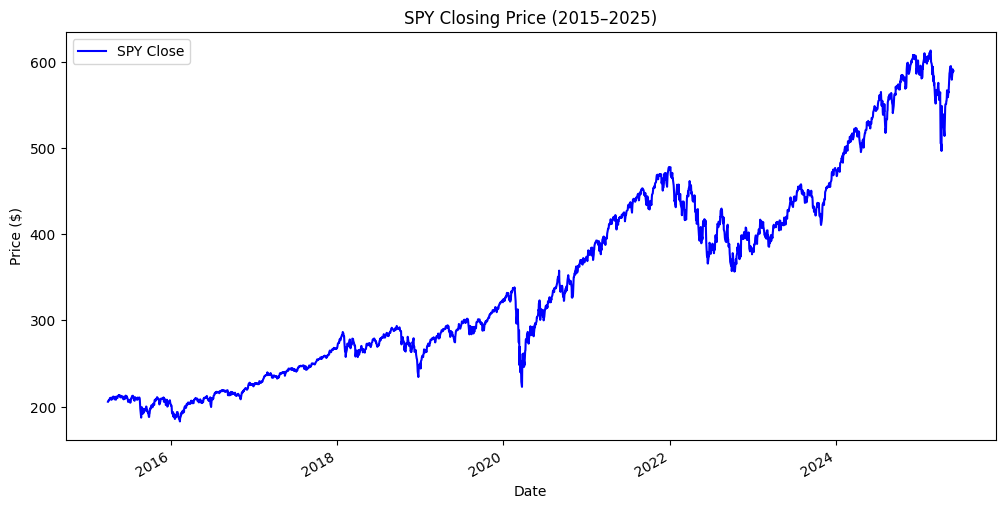

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,6))
eda_df["Close"].plot(ax=ax1, color="blue", label="SPY Close")
ax1.set_title("SPY Closing Price (2015–2025)")
ax1.set_ylabel("Price ($)")
ax1.legend()
plt.show()


### Inflation (CPI) VS SPY Price

CPI = main measure of inflation in the United States.

CPI tracks the average change over time in the prices paid by urban consumers for a basket of goods and services — like food, housing, clothing, transportation, and medical care.

This inverse visual pattern supports the idea: rising inflation → Fed rate hikes → lower SPY.

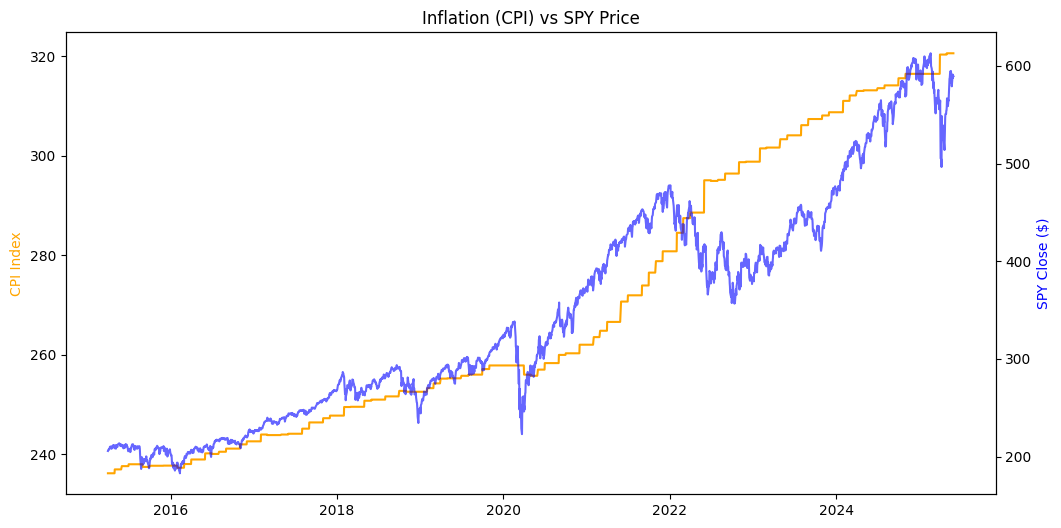

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(eda_df.index, eda_df["CPI"], label="CPI (Index)", color="orange")
ax1.set_ylabel("CPI Index", color="orange")

ax2 = ax1.twinx()
ax2.plot(eda_df.index, eda_df["Close"], label="SPY Close", color="blue", alpha=0.6)
ax2.set_ylabel("SPY Close ($)", color="blue")

plt.title("Inflation (CPI) vs SPY Price")
plt.show()

### Employment Growth
Payrolls rise in expansions (2015–2019, 2021 rebound), dip in recessions (2020).

Unemployment spikes during recessions — see the 2020 jump.

Markets tend to anticipate these: SPY often falls before unemployment rises.

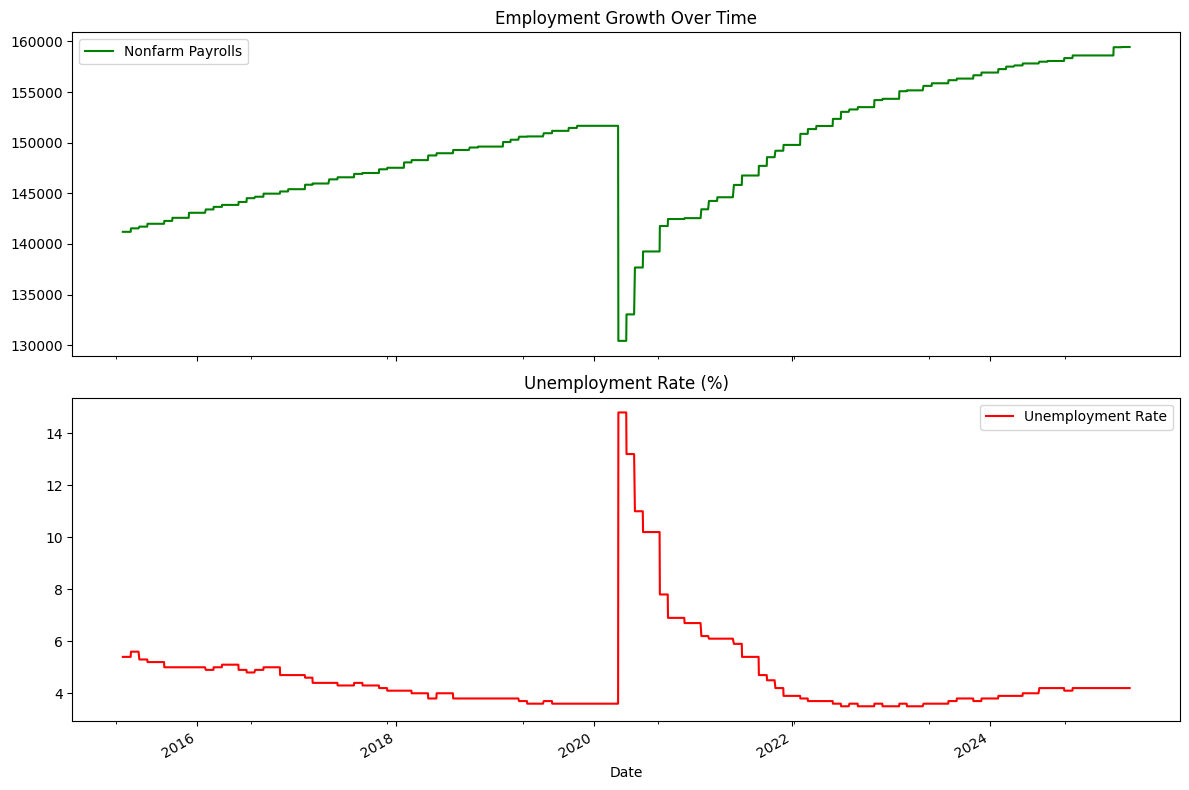

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(12,8), sharex=True)
eda_df["Payrolls"].plot(ax=ax[0], color="green", label="Nonfarm Payrolls")
ax[0].set_title("Employment Growth Over Time")
ax[0].legend()

eda_df["Unemployment"].plot(ax=ax[1], color="red", label="Unemployment Rate")
ax[1].set_title("Unemployment Rate (%)")
ax[1].legend()
plt.tight_layout()
plt.show()


### Term Spread
term spread measures the difference between long-term and short-term borrowing costs for the U.S. government.

When this line goes below 0, short-term rates > long-term → “inverted yield curve.”

Historically predicts recessions (e.g., inverted in 2019 before 2020 recession, again in 2022).

SPY often peaks before or near these inversions.

### Term Spread	What it means	Economic interpretation
- Positive (normal)	10-year > 2-year	Investors expect future growth and inflation → they demand higher yields for long-term bonds → economy healthy.

- Shrinking (flattening)	10-year ≈ 2-year	Investors expect slower growth → starting to get cautious about the future.

- Negative (inverted)	10-year < 2-year	Investors expect a recession → they think rates will fall later → buy long-term bonds now.

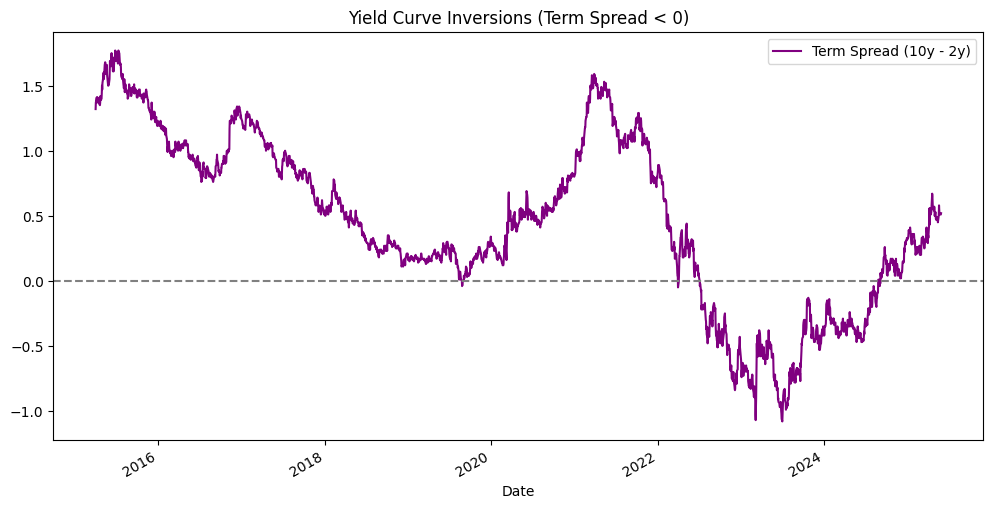

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,6))
eda_df["TermSpread"].plot(ax=ax1, color="purple", label="Term Spread (10y - 2y)")
ax1.axhline(0, color="gray", linestyle="--")
ax1.set_title("Yield Curve Inversions (Term Spread < 0)")
ax1.legend()
plt.show()

Spikes in VIX = panic / high fear (e.g., March 2020).

Usually coincides with big SPY drops.

When VIX falls back to low levels → calm / bullish regime.

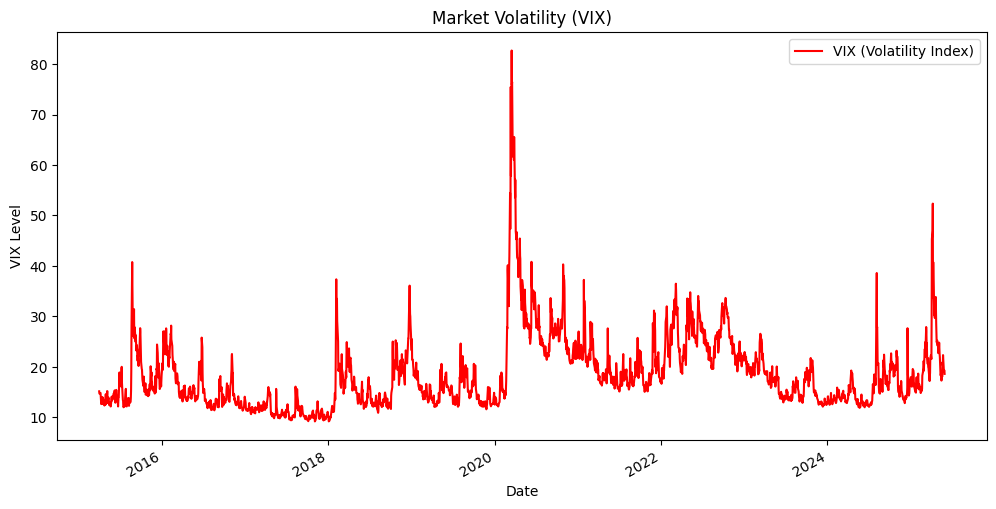

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
eda_df["VIX"].plot(color="red", label="VIX (Volatility Index)")
ax.set_title("Market Volatility (VIX)")
ax.set_ylabel("VIX Level")
ax.legend()
plt.show()

## Correlation Heatmap

### set the threshold of 0.8 with "Close" to find the strong correlation
=> CPI, CorePCE, RetailSales, DurGoodsOrders
1. CorePCE and Retail Sales
2. CPI
3. DurGoodsOrders


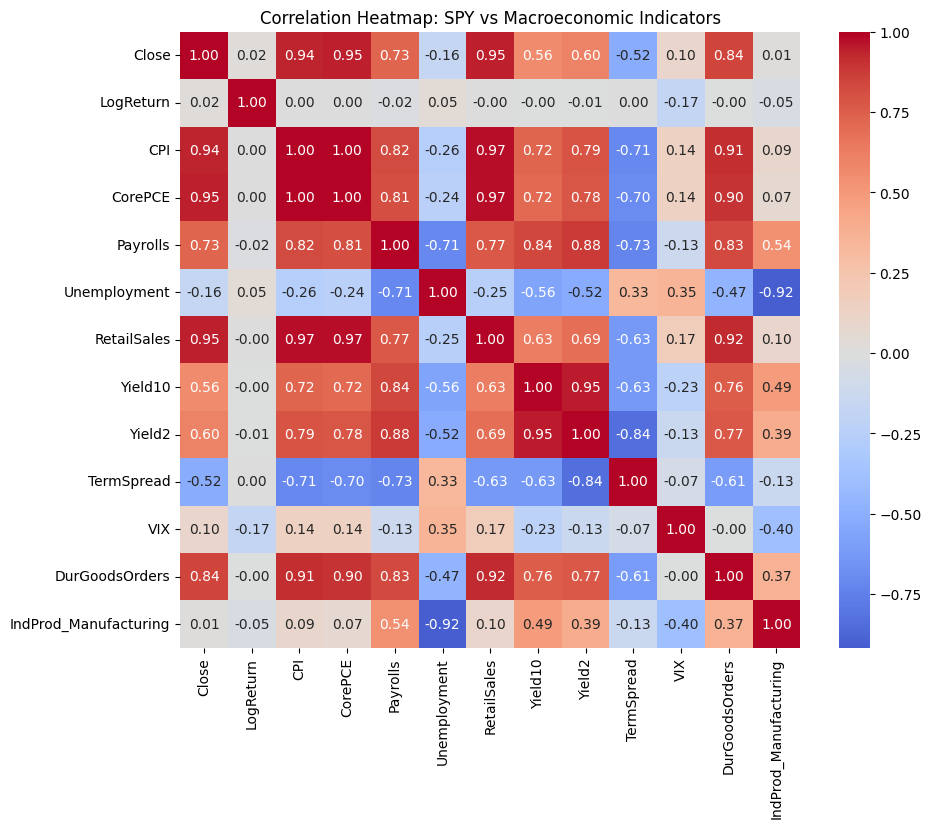

In [ ]:
corr = eda_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Correlation Heatmap: SPY vs Macroeconomic Indicators")
plt.show()

SPY returns often negative when VIX is high → market stress = selloff.

SPY returns sometimes positive when TermSpread is steep → healthy yield curve = optimism.

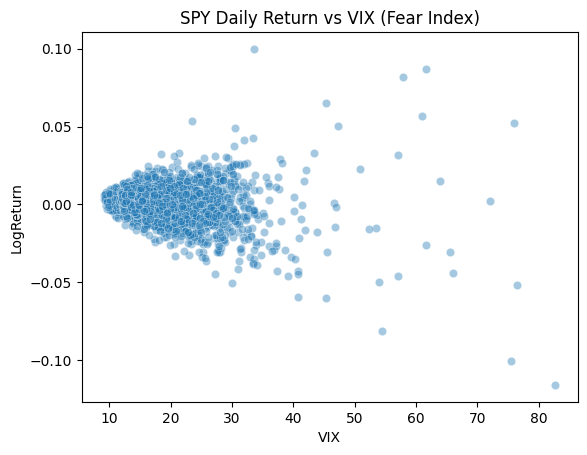

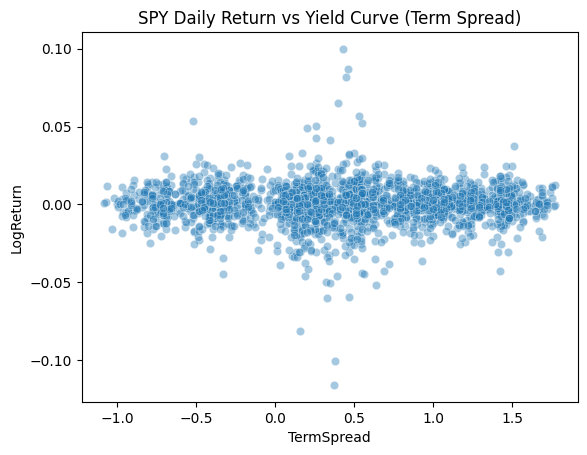

In [ ]:
sns.scatterplot(x="VIX", y="LogReturn", data=eda_df, alpha=0.4)
plt.title("SPY Daily Return vs VIX (Fear Index)")
plt.show()

sns.scatterplot(x="TermSpread", y="LogReturn", data=eda_df, alpha=0.4)
plt.title("SPY Daily Return vs Yield Curve (Term Spread)")
plt.show()

In [ ]:
df.columns

Index(['AdjClose', 'Close', 'High', 'Low', 'Open', 'Volume', 'CPI', 'CorePCE', 'Payrolls', 'Unemployment', 'RetailSales', 'Yield10', 'Yield2', 'VIX',
       'DurGoodsOrders', 'CoreCapexOrders', 'IndProd_Manufacturing', 'TermSpread'],
      dtype='object')

# Positions


In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Load SPY prices (you already have this, but just in case)
spy = yf.download("SPY", start="2014-12-31", end="2025-06-02")
spy.index = pd.to_datetime(spy.index)

/tmp/ipython-input-3156218350.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start="2014-12-31", end="2025-06-02")
[*********************100%***********************]  1 of 1 completed


In [ ]:
spy

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
2014-12-31,171.185287,205.539993,208.190002,205.389999,207.990005,130333800
2015-01-02,171.093704,205.429993,206.880005,204.179993,206.380005,121465900
2015-01-05,168.003845,201.720001,204.369995,201.350006,204.169998,169632600
2015-01-06,166.421341,199.820007,202.720001,198.860001,202.089996,209151400
2015-01-07,168.495163,202.309998,202.720001,200.880005,201.419998,125346700
...,...,...,...,...,...,...
2025-05-23,575.806641,579.109985,581.809998,575.599976,575.979980,76029000
2025-05-27,587.778015,591.150024,591.309998,578.429993,586.070007,72588500


## SVN and HMM


Train shape: (1701, 15) Test shape: (854, 15)
Best SVR params: {'svr__C': 1, 'svr__epsilon': 0.01, 'svr__gamma': 0.01}
SVR Test MSE (price): 10997.303997395726
HMM+SVR Test MSE (price): 10710.767129432768
Naive baseline Test MSE (Price_{t+1} = Price_{t}): 30.759499427569857


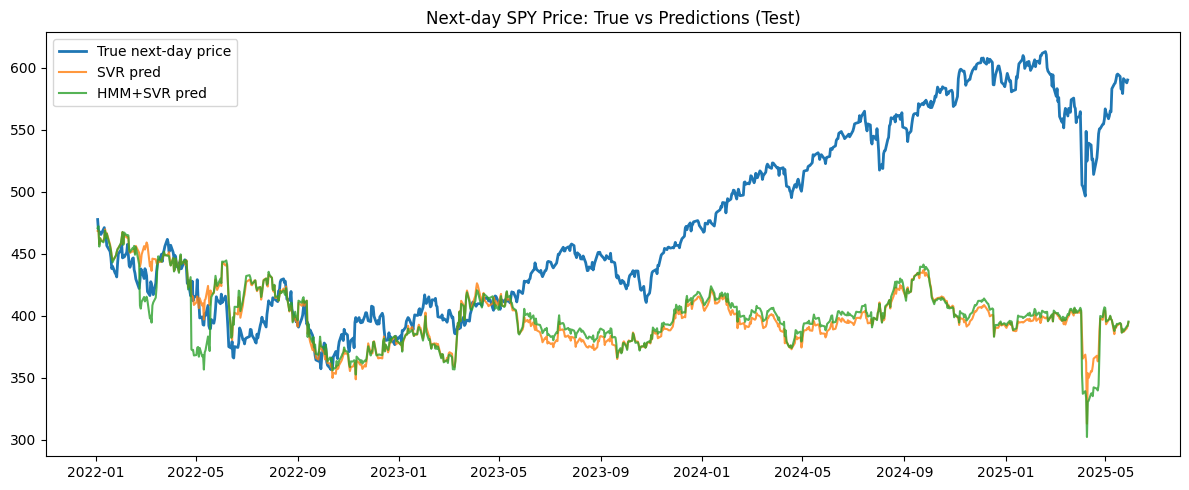


======== RESULTS (Test MSE on Price) ========
Naive:     30.759499
SVR:       10,997.303997
HMM+SVR:   10,710.767129


In [ ]:
# ============================================================
# 0) Install deps & imports
# ============================================================
!pip install -q scikit-learn hmmlearn

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

# ============================================================
# 1) Use your existing df (must already be in memory)
#    Your columns:
#    ['AdjClose','Close','High','Low','Open','Volume','CPI','CorePCE','Payrolls','Unemployment',
#     'RetailSales','Yield10','Yield2','VIX','DurGoodsOrders','CoreCapexOrders','IndProd_Manufacturing','TermSpread']
# ============================================================
assert 'df' in globals(), "DataFrame `df` not found. Please run the data-collection step first."
data = df.sort_index().copy()

# ============================================================
# 2) Minimal leakage guard for low-frequency series (shift by 1b day)
# ============================================================
monthly_like = [
    "CPI","CorePCE","Payrolls","Unemployment","RetailSales",
    "DurGoodsOrders","CoreCapexOrders","IndProd_Manufacturing"
]
for c in monthly_like:
    if c in data.columns:
        data[c] = data[c].shift(1)

# ============================================================
# 3) Feature engineering (light, stable)
# ============================================================
data["LogClose"] = np.log(data["Close"])
data["Ret1"]     = data["LogClose"].diff(1)
data["Ret5"]     = data["LogClose"].diff(5)
data["Vol10"]    = data["Ret1"].rolling(10).std()

# Target = next-day log price; evaluate MSE on price later
data["y_next_log_close"] = data["LogClose"].shift(-1)

# Drop edges
data_ml = data.dropna().copy()

# Feature set (macro/growth + light technicals)
features = [
    "CPI","CorePCE","Payrolls","Unemployment","RetailSales",
    "Yield10","Yield2","TermSpread","VIX",
    "DurGoodsOrders","CoreCapexOrders","IndProd_Manufacturing",
    "Ret1","Ret5","Vol10"
]
features = [f for f in features if f in data_ml.columns]  # robustness

X_full   = data_ml[features].values
y_log    = data_ml["y_next_log_close"].values
idx_full = data_ml.index

# ============================================================
# 4) Train / Test split (assignment spec)
# ============================================================
train_start, train_end = "2015-01-01", "2021-12-31"
test_start,  test_end  = "2022-01-01", "2025-06-01"

mask_train = (idx_full >= train_start) & (idx_full <= train_end)
mask_test  = (idx_full >= test_start)  & (idx_full <= test_end)

X_train, y_train_log = X_full[mask_train], y_log[mask_train]
X_test,  y_test_log  = X_full[mask_test],  y_log[mask_test]
idx_train = idx_full[mask_train]
idx_test  = idx_full[mask_test]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# ============================================================
# 5) SVR (RBF) with TimeSeries CV
# ============================================================
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf"))
])

param_grid = {
    "svr__C": [1, 10, 100],
    "svr__epsilon": [0.01, 0.05, 0.1],
    "svr__gamma": ["scale", 0.1, 0.01]
}

tscv = TimeSeriesSplit(n_splits=5)
gcv = GridSearchCV(pipe, param_grid, scoring="neg_mean_squared_error", cv=tscv, n_jobs=-1)
gcv.fit(X_train, y_train_log)

best_svr = gcv.best_estimator_
print("Best SVR params:", gcv.best_params_)

# Predict (log) -> price; compute MSE on price
y_pred_log_svr   = best_svr.predict(X_test)
y_pred_price_svr = np.exp(y_pred_log_svr)
y_true_price     = np.exp(y_test_log)
mse_svr = mean_squared_error(y_true_price, y_pred_price_svr)
print("SVR Test MSE (price):", mse_svr)

# ============================================================
# 6) HMM regimes -> add state probs to features -> SVR again
#    (OVERLAP-SAFE PROBABILITY MERGE)
# ============================================================
# HMM inputs compact & quasi-stationary
hmm_cols = [c for c in ["Ret1","Vol10","VIX","TermSpread"] if c in data_ml.columns]
Z = data_ml[hmm_cols].dropna().copy()

# Align to HMM index
hm_idx = Z.index
hm_train_mask = (hm_idx >= train_start) & (hm_idx <= train_end)
hm_test_mask  = (hm_idx >= test_start)  & (hm_idx <= test_end)

Z_train, Z_test = Z.loc[hm_train_mask].values, Z.loc[hm_test_mask].values

# Fit HMM on train
hmm = GaussianHMM(n_components=3, covariance_type="diag", n_iter=500, random_state=0)
hmm.fit(Z_train)

def hmm_probs_block(Z_block, idx_block):
    P = hmm.predict_proba(Z_block)  # (n, n_states)
    return pd.DataFrame(P, index=idx_block, columns=[f"hmm_state_{k}" for k in range(P.shape[1])])

train_probs = hmm_probs_block(Z_train, Z.index[hm_train_mask])
test_probs  = hmm_probs_block(Z_test,  Z.index[hm_test_mask])

# --------- FIX: build a single full probability table, avoid overlapping-join error ---------
state_cols = [f"hmm_state_{k}" for k in range(hmm.n_components)]
probs_full = pd.DataFrame(index=data_ml.index, columns=state_cols, dtype=float)
probs_full.loc[train_probs.index, state_cols] = train_probs.values
probs_full.loc[test_probs.index,  state_cols] = test_probs.values
probs_full = probs_full.ffill()  # bridge small gaps
# -------------------------------------------------------------------------------------------

# Merge probabilities into ML frame
data_aug = pd.concat([data_ml, probs_full], axis=1)

# Build augmented matrices
features_aug = features + state_cols
X_aug  = data_aug[features_aug].values
y_log2 = data_aug["y_next_log_close"].values
idx2   = data_aug.index

mask_train2 = (idx2 >= train_start) & (idx2 <= train_end)
mask_test2  = (idx2 >= test_start)  & (idx2 <= test_end)

X_train_aug, y_train_log_aug = X_aug[mask_train2], y_log2[mask_train2]
X_test_aug,  y_test_log_aug  = X_aug[mask_test2],  y_log2[mask_test2]
idx_test_aug = idx2[mask_test2]

# Refit SVR with same best params for stability
best_svr.fit(X_train_aug, y_train_log_aug)
y_pred_log_hmm   = best_svr.predict(X_test_aug)
y_pred_price_hmm = np.exp(y_pred_log_hmm)
y_true_price_hmm = np.exp(y_test_log_aug)
mse_hmm_svr = mean_squared_error(y_true_price_hmm, y_pred_price_hmm)
print("HMM+SVR Test MSE (price):", mse_hmm_svr)

# ============================================================
# 7) Baseline: Price_{t+1} = Price_{t}
# ============================================================
close_series = data_ml["Close"]
true_next_price = close_series.loc[test_start:test_end].shift(-1).dropna()
today_price     = close_series.loc[test_start:test_end]
today_price     = today_price.loc[true_next_price.index]
mse_naive = mean_squared_error(true_next_price.values, today_price.values)
print("Naive baseline Test MSE (Price_{t+1} = Price_{t}):", mse_naive)

# ============================================================
# 8) Plot (optional)
# ============================================================
plt.figure(figsize=(12,5))
plt.plot(true_next_price.index, true_next_price.values, label="True next-day price", linewidth=2)
plt.plot(idx_test, y_pred_price_svr, label="SVR pred", alpha=0.8)
plt.plot(idx_test_aug, y_pred_price_hmm, label="HMM+SVR pred", alpha=0.8)
plt.title("Next-day SPY Price: True vs Predictions (Test)")
plt.legend()
plt.tight_layout()
plt.show()

print("\n======== RESULTS (Test MSE on Price) ========")
print(f"Naive:     {mse_naive:,.6f}")
print(f"SVR:       {mse_svr:,.6f}")
print(f"HMM+SVR:   {mse_hmm_svr:,.6f}")


Train: (1701, 6) Test: (854, 6)
Test starts at actual trading day: 2022-01-03
Best SVR params: {'svr__C': 10, 'svr__epsilon': 0.01, 'svr__gamma': 'scale'}
SVR MSE (price): 34810.571515324715
HMM-only MSE (price): 30.6641536370445
HMM+SVR MSE (price): 29590.956992594685


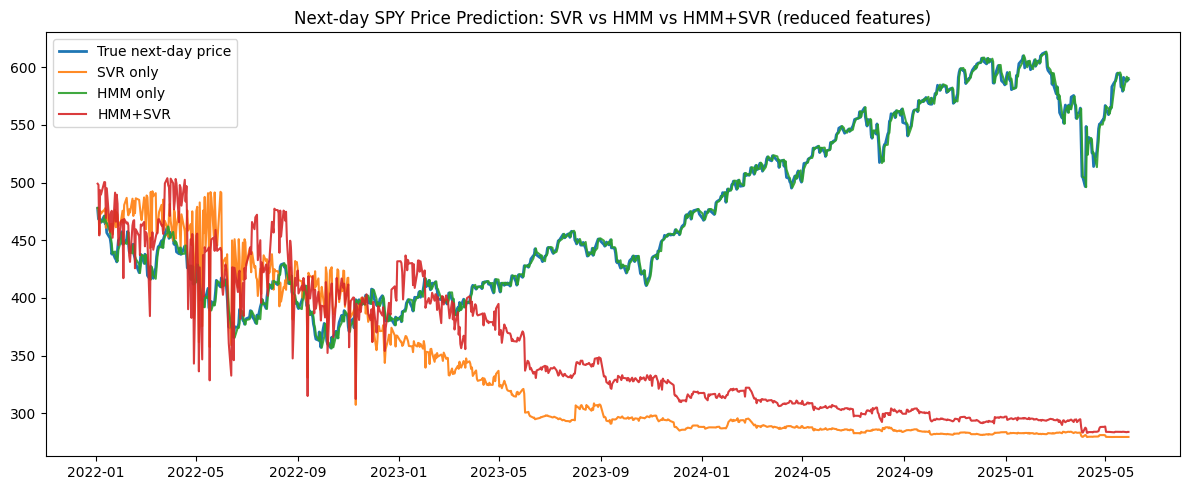


======== TEST MSE (price) ========
SVR only:  34,810.5715
HMM only:  30.6642
HMM+SVR:   29,590.9570


In [ ]:
# ============================================================
# 0) Install deps & imports
# ============================================================
!pip install -q scikit-learn hmmlearn

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

# ============================================================
# 1) Data (assumes df already exists with your columns)
# ============================================================
assert 'df' in globals(), "Run your data-collection cell first."

# Use only the top-correlated macro features you specified
selected_macros = ["CPI", "CorePCE", "RetailSales", "DurGoodsOrders"]
data = df.sort_index().copy()

# Guard against look-ahead for monthly-like series
for c in selected_macros:
    data[c] = data[c].shift(1)

# Light, stable technicals
data["LogClose"] = np.log(data["Close"])
data["Ret1"]     = data["LogClose"].diff(1)
data["Vol10"]    = data["Ret1"].rolling(10).std()

# Target: next-day log price; we'll evaluate on PRICE MSE
data["y_next_log_close"] = data["LogClose"].shift(-1)

# Drop edges
data = data.dropna().copy()

# Feature sets
features = selected_macros + ["Ret1", "Vol10"]
X_full = data[features].values
y_log  = data["y_next_log_close"].values
idx    = data.index

# ============================================================
# 2) Train/Test split (by index, not hard-coded dates)
# ============================================================
train_start, train_end = "2015-01-01", "2021-12-31"
test_start,  test_end  = "2022-01-01", "2025-06-01"

mask_train = (idx >= train_start) & (idx <= train_end)
mask_test  = (idx >= test_start)  & (idx <= test_end)

X_train, y_train_log = X_full[mask_train], y_log[mask_train]
X_test,  y_test_log  = X_full[mask_test],  y_log[mask_test]
idx_train = idx[mask_train]
idx_test  = idx[mask_test]   # <-- actual trading-day index, avoids 2022-01-01 error

y_true_price = np.exp(y_test_log)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Test starts at actual trading day:", idx_test[0].date())

# ============================================================
# 3) SVR only  (regularized to curb overfitting)
# ============================================================
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf"))
])

param_grid = {
    "svr__C": [0.1, 1, 10],      # smaller C => stronger regularization
    "svr__epsilon": [0.01, 0.05],
    "svr__gamma": ["scale"]      # keep simple; avoids overfitting with tiny gammas
}

tscv = TimeSeriesSplit(n_splits=5)
gcv = GridSearchCV(pipe, param_grid, scoring="neg_mean_squared_error", cv=tscv, n_jobs=-1)
gcv.fit(X_train, y_train_log)

best_svr = gcv.best_estimator_
print("Best SVR params:", gcv.best_params_)

y_pred_log_svr   = best_svr.predict(X_test)
y_pred_price_svr = np.exp(y_pred_log_svr)
mse_svr = mean_squared_error(y_true_price, y_pred_price_svr)
print("SVR MSE (price):", mse_svr)

# ============================================================
# 4) HMM only  (2 states, stable; one-step-ahead forecast)
# ============================================================
# Use stationary-ish inputs for HMM
hmm_inputs = data[["Ret1", "Vol10"]].dropna()
hm_idx = hmm_inputs.index

hm_train_mask = (hm_idx >= train_start) & (hm_idx <= train_end)
hm_test_mask  = (hm_idx >= test_start)  & (hm_idx <= test_end)

Z_train = hmm_inputs.loc[hm_train_mask].values
Z_test  = hmm_inputs.loc[hm_test_mask].values
idx_hmm_test = hmm_inputs.index[hm_test_mask]

# Fit a compact, robust HMM
hmm = GaussianHMM(n_components=2, covariance_type="diag", n_iter=300, random_state=0)

hmm.fit(Z_train)

# Expected next-day return for each test day = mean Ret1 of the most likely state
states_test    = hmm.predict(Z_test)
state_ret_means = hmm.means_[:, 0]  # column 0 corresponds to Ret1
exp_ret_next   = state_ret_means[states_test]  # one-step-ahead expected return

# One-step price forecast: P_{t+1} = P_t * exp(expected_ret_{t+1})
curr_close_on_test = data.loc[idx_hmm_test, "Close"].values
y_pred_price_hmm_only = curr_close_on_test * np.exp(exp_ret_next)

# Align with y_true_price (idx_test). If HMM test index equals idx_test, we're good;
# if not (due to extra NaN drops), align by index intersection:
align_idx = idx_test.intersection(idx_hmm_test)
y_true_price_aligned = np.exp(data.loc[align_idx, "y_next_log_close"].values)
y_pred_price_hmm_only = y_pred_price_hmm_only[np.isin(idx_hmm_test, align_idx)]

mse_hmm_only = mean_squared_error(y_true_price_aligned, y_pred_price_hmm_only)
print("HMM-only MSE (price):", mse_hmm_only)

# ============================================================
# 5) HMM + SVR  (add state probabilities as features)
# ============================================================
P_train = hmm.predict_proba(Z_train)
P_test  = hmm.predict_proba(Z_test)
state_cols = [f"hmm_state_{i}" for i in range(P_train.shape[1])]

# Build one aligned probability table, then concat
probs_full = pd.DataFrame(index=data.index, columns=state_cols, dtype=float)
probs_full.loc[hmm_inputs.index[hm_train_mask], state_cols] = P_train
probs_full.loc[hmm_inputs.index[hm_test_mask],  state_cols] = P_test
probs_full = probs_full.ffill()

data_aug = pd.concat([data, probs_full], axis=1)

features_aug = features + state_cols
X_aug  = data_aug[features_aug].values
y_log2 = data_aug["y_next_log_close"].values
idx2   = data_aug.index

mask_train2 = (idx2 >= train_start) & (idx2 <= train_end)
mask_test2  = (idx2 >= test_start)  & (idx2 <= test_end)

X_train_aug, y_train_aug = X_aug[mask_train2], y_log2[mask_train2]
X_test_aug,  y_test_aug  = X_aug[mask_test2],  y_log2[mask_test2]
idx_test_aug = idx2[mask_test2]

# Reuse best SVR (regularized) for stability
best_svr.fit(X_train_aug, y_train_aug)
y_pred_log_hmm_svr   = best_svr.predict(X_test_aug)
y_pred_price_hmm_svr = np.exp(y_pred_log_hmm_svr)
mse_hmm_svr = mean_squared_error(np.exp(y_test_aug), y_pred_price_hmm_svr)
print("HMM+SVR MSE (price):", mse_hmm_svr)

# ============================================================
# 6) Plot all three
# ============================================================
plt.figure(figsize=(12,5))
plt.plot(idx_test, y_true_price, label="True next-day price", linewidth=2)
plt.plot(idx_test, y_pred_price_svr, label="SVR only", alpha=0.9)
plt.plot(align_idx, y_pred_price_hmm_only, label="HMM only", alpha=0.9)
plt.plot(idx_test_aug, y_pred_price_hmm_svr, label="HMM+SVR", alpha=0.9)
plt.title("Next-day SPY Price Prediction: SVR vs HMM vs HMM+SVR (reduced features)")
plt.legend()
plt.tight_layout()
plt.show()

print("\n======== TEST MSE (price) ========")
print(f"SVR only:  {mse_svr:,.4f}")
print(f"HMM only:  {mse_hmm_only:,.4f}")
print(f"HMM+SVR:   {mse_hmm_svr:,.4f}")


Train: (1701, 6) Test: (854, 6)
Test starts at: 2022-01-03
Best SVR params: {'svr__C': 10, 'svr__epsilon': 0.01, 'svr__gamma': 'scale'}
SVR MSE (price): 34810.571515324715
HMM-only MSE (price): 30.74583831854822 | aligned points: 854
Augmented shapes — Train: (1701, 8) Test: (854, 8)
HMM+SVR MSE (price): 29253.876961141974


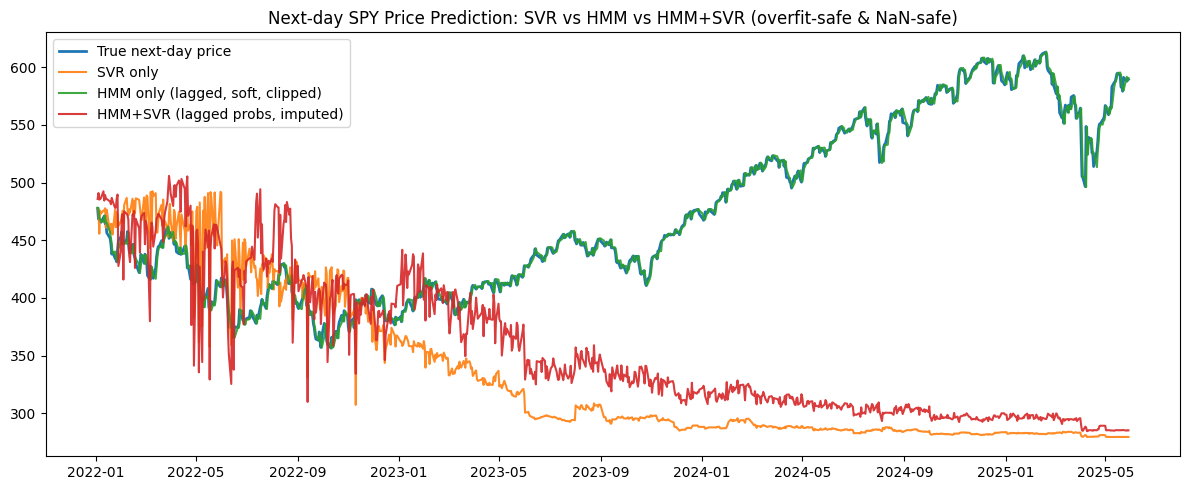


======== TEST MSE (price) ========
SVR only:             34,810.5715
HMM only (safe):      30.7458
HMM+SVR (NaN-safe):   29,253.8770


In [ ]:
# ============================================================
# 0) Install deps & imports
# ============================================================
!pip install -q scikit-learn hmmlearn

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

# ============================================================
# 1) Data (assumes df already exists with your columns)
# ============================================================
assert 'df' in globals(), "Run your data-collection cell first."

selected_macros = ["CPI", "CorePCE", "RetailSales", "DurGoodsOrders"]
data = df.sort_index().copy()

# Prevent look-ahead on monthly releases
for c in selected_macros:
    data[c] = data[c].shift(1)

# Light technicals
data["LogClose"] = np.log(data["Close"])
data["Ret1"]     = data["LogClose"].diff(1)
data["Vol10"]    = data["Ret1"].rolling(10).std()

# Target = next-day log price (assignment metric is MSE on price)
data["y_next_log_close"] = data["LogClose"].shift(-1)

# Drop edges
data = data.dropna().copy()

# Features
features = selected_macros + ["Ret1", "Vol10"]
X_full = data[features].values
y_log  = data["y_next_log_close"].values
idx    = data.index

# ============================================================
# 2) Train/Test split (by index)
# ============================================================
train_start, train_end = "2015-01-01", "2021-12-31"
test_start,  test_end  = "2022-01-01", "2025-06-01"

mask_train = (idx >= train_start) & (idx <= train_end)
mask_test  = (idx >= test_start)  & (idx <= test_end)

X_train, y_train_log = X_full[mask_train], y_log[mask_train]
X_test,  y_test_log  = X_full[mask_test],  y_log[mask_test]
idx_train = idx[mask_train]
idx_test  = idx[mask_test]

y_true_price = np.exp(y_test_log)
print("Train:", X_train.shape, "Test:", X_test.shape)
print("Test starts at:", idx_test[0].date())

# ============================================================
# 3) SVR only (add imputer to be safe)
# ============================================================
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf"))
])

param_grid = {
    "svr__C": [0.1, 1, 10],
    "svr__epsilon": [0.01, 0.05],
    "svr__gamma": ["scale"]
}

tscv = TimeSeriesSplit(n_splits=5)
gcv = GridSearchCV(pipe, param_grid, scoring="neg_mean_squared_error", cv=tscv, n_jobs=-1)
gcv.fit(X_train, y_train_log)

best_svr = gcv.best_estimator_
print("Best SVR params:", gcv.best_params_)

y_pred_log_svr   = best_svr.predict(X_test)
y_pred_price_svr = np.exp(y_pred_log_svr)
mse_svr = mean_squared_error(y_true_price, y_pred_price_svr)
print("SVR MSE (price):", mse_svr)

# ============================================================
# 4) HMM only (lagged inputs + soft probs + clipping)
# ============================================================
# Lag the inputs so HMM uses info up to t-1 to forecast t+1
hmm_inputs = data[["Ret1", "Vol10"]].shift(1).dropna()
hm_idx = hmm_inputs.index

hm_train_mask = (hm_idx >= train_start) & (hm_idx <= train_end)
hm_test_mask  = (hm_idx >= test_start)  & (hm_idx <= test_end)

Z_train = hmm_inputs.loc[hm_train_mask].values
Z_test  = hmm_inputs.loc[hm_test_mask].values
idx_hmm_test = hmm_inputs.index[hm_test_mask]

# Build HMM with covariance floor (handles hmmlearn version differences)
def make_hmm():
    try:
        return GaussianHMM(n_components=2, covariance_type="diag",
                           n_iter=300, random_state=0, tol=1e-3, reg_covar=1e-6)
    except TypeError:
        try:
            return GaussianHMM(n_components=2, covariance_type="diag",
                               n_iter=300, random_state=0, tol=1e-3, min_covar=1e-6)
        except TypeError:
            return GaussianHMM(n_components=2, covariance_type="diag",
                               n_iter=300, random_state=0, tol=1e-3)

hmm = make_hmm()
hmm.fit(Z_train)

# Soft expectation with clipping
P_test = hmm.predict_proba(Z_test)
state_ret_means = hmm.means_[:, 0]
exp_ret_next = P_test @ state_ret_means

train_ret_std = data.loc[train_start:train_end, "Ret1"].std()
exp_ret_next = np.clip(exp_ret_next, -3*train_ret_std, 3*train_ret_std)

# One-step price forecast
curr_close_on_test = data.loc[idx_hmm_test, "Close"].values
y_pred_price_hmm_only = curr_close_on_test * np.exp(exp_ret_next)

# Align with evaluation index
align_idx = idx_test.intersection(idx_hmm_test)
y_true_price_aligned = np.exp(data.loc[align_idx, "y_next_log_close"].values)
y_pred_price_hmm_only = y_pred_price_hmm_only[np.isin(idx_hmm_test, align_idx)]

mse_hmm_only = mean_squared_error(y_true_price_aligned, y_pred_price_hmm_only)
print("HMM-only MSE (price):", mse_hmm_only, "| aligned points:", len(align_idx))

# ============================================================
# 5) HMM + SVR (feed LAGGED probs; ensure no NaNs)
# ============================================================
P_train = hmm.predict_proba(Z_train)
state_cols = [f"hmm_state_{i}" for i in range(P_train.shape[1])]

probs_full = pd.DataFrame(index=data.index, columns=state_cols, dtype=float)
probs_full.loc[hmm_inputs.index[hm_train_mask], state_cols] = P_train
probs_full.loc[hmm_inputs.index[hm_test_mask],  state_cols] = P_test

# Shift one more day so features at t reflect info up to t-1, then fill
probs_full = probs_full.shift(1).ffill().bfill()

data_aug = pd.concat([data, probs_full], axis=1)

features_aug = features + state_cols

# Forward/backward fill the augmented feature block to eliminate any gaps,
# then drop any rows that still have NaNs in features or target.
data_aug[features_aug] = data_aug[features_aug].ffill().bfill()
data_aug = data_aug.dropna(subset=features_aug + ["y_next_log_close"])

X_aug  = data_aug[features_aug].values
y_log2 = data_aug["y_next_log_close"].values
idx2   = data_aug.index

mask_train2 = (idx2 >= train_start) & (idx2 <= train_end)
mask_test2  = (idx2 >= test_start)  & (idx2 <= test_end)

# Keep only rows fully valid within each split
X_train_aug, y_train_aug = X_aug[mask_train2], y_log2[mask_train2]
X_test_aug,  y_test_aug  = X_aug[mask_test2],  y_log2[mask_test2]
idx_test_aug = idx2[mask_test2]

print("Augmented shapes — Train:", X_train_aug.shape, "Test:", X_test_aug.shape)

# Reuse best SVR (now with imputer inside)
best_svr.fit(X_train_aug, y_train_aug)
y_pred_log_hmm_svr   = best_svr.predict(X_test_aug)
y_pred_price_hmm_svr = np.exp(y_pred_log_hmm_svr)
mse_hmm_svr = mean_squared_error(np.exp(y_test_aug), y_pred_price_hmm_svr)
print("HMM+SVR MSE (price):", mse_hmm_svr)

# ============================================================
# 6) Plot all three
# ============================================================
plt.figure(figsize=(12,5))
plt.plot(idx_test, y_true_price, label="True next-day price", linewidth=2)
plt.plot(idx_test, y_pred_price_svr, label="SVR only", alpha=0.9)
plt.plot(align_idx, y_pred_price_hmm_only, label="HMM only (lagged, soft, clipped)", alpha=0.9)
plt.plot(idx_test_aug, y_pred_price_hmm_svr, label="HMM+SVR (lagged probs, imputed)", alpha=0.9)
plt.title("Next-day SPY Price Prediction: SVR vs HMM vs HMM+SVR (overfit-safe & NaN-safe)")
plt.legend()
plt.tight_layout()
plt.show()

print("\n======== TEST MSE (price) ========")
print(f"SVR only:             {mse_svr:,.4f}")
print(f"HMM only (safe):      {mse_hmm_only:,.4f}")
print(f"HMM+SVR (NaN-safe):   {mse_hmm_svr:,.4f}")


In [ ]:
df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'CPI', 'CorePCE', 'Payrolls', 'Unemployment', 'RetailSales', 'Yield10', 'Yield2', 'VIX',
       'DurGoodsOrders', 'CoreCapexOrders', 'IndProd_Manufacturing', 'TermSpread', 'Target', 'Returns', 'Log_Returns', 'SMA_5', 'Close_to_SMA_5', 'SMA_10',
       'Close_to_SMA_10', 'SMA_20', 'Close_to_SMA_20', 'SMA_50', 'Close_to_SMA_50', 'Volatility_5', 'Volatility_20', 'Return_Lag_1', 'Return_Lag_2',
       'Return_Lag_3', 'Return_Lag_5', 'Return_Lag_10', 'Return_Lag_20', 'Volume_MA_20', 'Volume_Ratio', 'HL_Ratio', 'RSI_14', 'MACD', 'MACD_Signal',
       'MACD_Diff', 'CPI_Pct_1M', 'CPI_Pct_3M', 'CPI_Zscore', 'CorePCE_Pct_1M', 'CorePCE_Pct_3M', 'CorePCE_Zscore', 'Payrolls_Pct_1M', 'Payrolls_Pct_3M',
       'Payrolls_Zscore', 'Unemployment_Pct_1M', 'Unemployment_Pct_3M', 'Unemployment_Zscore', 'RetailSales_Pct_1M', 'RetailSales_Pct_3M',
       'RetailSales_Zscore', 'Yield10_Pct_1M', 'Yield10_Pct_3M', 'Yield10_Zscore', 'Yield2_Pct_1M', '